# Part 1: Trilateration - Difference of Squares Algorithm

<div style="text-align: center;">
  <img src="./circles.png" alt="Trilateration Illustration" width="500"/>
</div>


### Problem Description:
The **goal** is to determine the coordinates of an unknown point $P(x, y)$ given the coordinates of **N** known points $P_1(x_{0}, y_{0}), P_1(x_{1}, y_{1}), \dots, P_{N-1}(x_{N-1}, y_{N-1})$ and their respective distances to the unknown point: $d_0, d_1, \dots, d_{N-1}$.

By elementary geometry, the following equations hold:

$$
d_i^2 = (x - x_i)^2 + (y - y_i)^2 \quad \text{for} \, i = 0, 1, \dots, N-1
$$

### Solving the Problem

We can choose one of the equations (e.g., the equation for $d_0$) as a reference equation, and subtract it from all other equations.

#### 1. Subtract Equation \( i \) from Equation 1:

We subtract the distance equation for point $ P_i(x_i, y_i)$ from the distance equation for $P_0(x_0, y_0)$:

$$
d_0^2 - d_i^2 = \left[ (x - x_0)^2 + (y - y_0)^2 \right] - \left[ (x - x_i)^2 + (y - y_i)^2 \right]
$$

Expanding both sides and canceling the common terms, we get:

$$
d_0^2 - d_i^2 = -2x(x_0 - x_i) - 2y(y_0 - y_i) + (x_0^2 - x_i^2) + (y_0^2 - y_i^2)
$$

Rearranging this, we obtain the linear equation in $x$ and $y$:

$$
2x(x_i - x_0) + 2y(y_i - y_0) = d_0^2 - d_i^2 + (x_i^2 - x_0^2) + (y_i^2 - y_0^2), \quad \text{for} \, i = 1, \dots, N-1
$$

This results in \( N-1 \) linear equations (since we subtract one equation from the rest).


#### 2. Put the Equation System in a Matrix Form:

Once we have the system of linear equations, we can express it in matrix form as:

$$
A \cdot [x, y]^T = b
$$

Where:
$$
A = \begin{bmatrix}
2(x_1 - x_0) & 2(y_1 - y_0) \\
2(x_2 - x_0) & 2(y_2 - y_0) \\
\vdots & \vdots \\
2(x_{N-1} - x_0) & 2(y_{N-1} - y_0)
\end{bmatrix}
$$

$$
b = \begin{bmatrix}
d_0^2 - d_1^2 + (x_1^2 - x_0^2) + (y_1^2 - y_0^2) \\
d_0^2 - d_2^2 + (x_2^2 - x_0^2) + (y_2^2 - y_0^2) \\
\vdots \\
d_0^2 - d_{N-1}^2 + (x_{N-1}^2 - x_0^2) + (y_{N-1}^2 - y_0^2)
\end{bmatrix}
$$


### Observation

- At least **two** of the known points must not be collinear (i.e., they must form a triangle).
- At least three points are necessary for the 2D case, and four points for the 3D case.
- If more than three anchors are used in 2D, there is no exact soluton and the system should be solved as a linear regression


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from trilateration_opt import trilateration_opt

## Exercise: Implement the Difference of Squares Trilateration Algorithm in Python

In [2]:
import numpy as np

def trilateration_dos(X, d):
    """
    Function to compute the unknown point P in dim-dimensional Euclidean space.

    Parameters:
    X (numpy.ndarray): A matrix of shape (n, dim) representing the coordinates 
                       of n known points in dim-dimensional space.
    d (numpy.ndarray): A 1D array of shape (n,) representing the distances 
                       from the unknown point to each of the known points.
    
    Returns:
    numpy.ndarray: A 1D array representing the coordinates of the unknown point in dim-dimensional space.

    Note: dim=2 for this exercise
    """


    n, dim = X.shape
    
    # Create an empty system of linear equations
    A = np.zeros((n - 1, dim))
    B = np.zeros(n - 1)
    
    for i in range(1, n):
        A[i - 1, :] = 2 * (X[i, :] - X[0, :])
        B[i - 1] = d[0]**2 - d[i]**2 + np.sum(X[i, :]**2) - np.sum(X[0, :]**2)

    # Solving the linear system
    try:
        solution = np.linalg.inv(A.T @ A) @ A.T @ B # Linear regression close form solutions
        # solution = np.linalg.solve(A, B)
        return solution
    except np.linalg.LinAlgError:
        return "The system cannot be solved."

### Scenario 1 - Robot surrounded by anchors

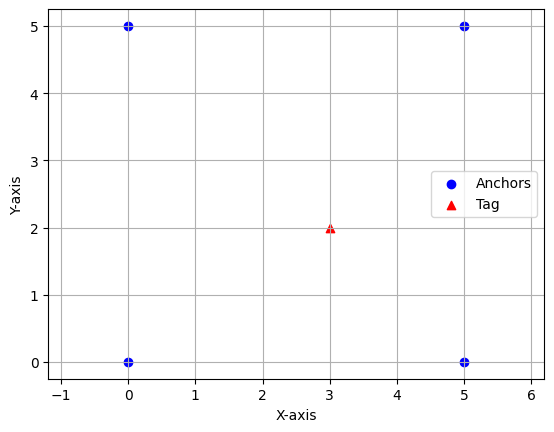

In [3]:
# Load data
data = np.load('data_close.npz')
plot_points_2d(data)

# Extract input variables
X = data['X']
uwb_distances = data['distances']

In [4]:
errors = []
for i in range(500):
    P_est = trilateration_dos(X, uwb_distances[i])
    error = np.linalg.norm(P_est - data['node_pos'])
    errors.append(error)
    
mean_error = np.mean(errors)
print("DoS Error: ", np.round(mean_error, 3))

DoS Error:  0.269


### Scenario 2 - Robot far from the anchors

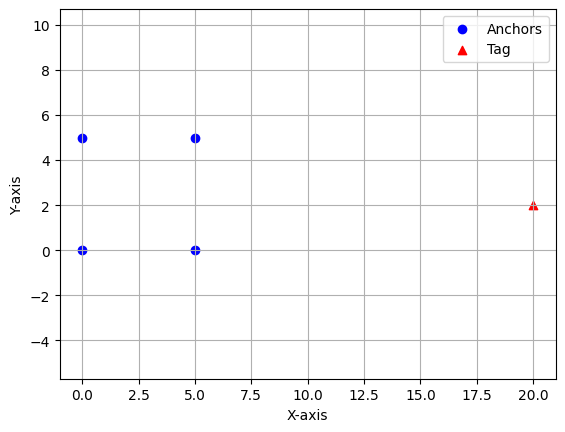

In [5]:
# Load data
data = np.load('data_far.npz')
plot_points_2d(data)

# Extract input variables
X = data['X']
uwb_distances = data['distances']

In [6]:
errors = []
for i in range(500):
    P_est = trilateration_dos(X, uwb_distances[i])
    error = np.linalg.norm(P_est - data['node_pos'])
    errors.append(error)
    
mean_error = np.mean(errors)
print("DoS Error: ", np.round(mean_error, 3))

DoS Error:  1.402


### Additional study
The *Difference of Squares Algorithm* does not attempt to minimize any cost function, and therefore it exhibits less robustness compared to the optimal trilateration introduced in the theoretical part of the workshop. The following cell performs the localization of **Scenario 2** using the optimal trilateration instead of the Difference of Squares Algorithm. Observe the results.


In [7]:
errors = []
for i in range(500):
    P_est = trilateration_opt(X, uwb_distances[i])
    error = np.linalg.norm(P_est - data['node_pos'])
    errors.append(error)
    
mean_error = np.mean(errors)
print("Optimal Trilateration Error: ", np.round(mean_error, 3))

Optimal Trilateration Error:  0.849


# Part 2: 2D Robot Localization using an Extended Kalman Filter (EKF)

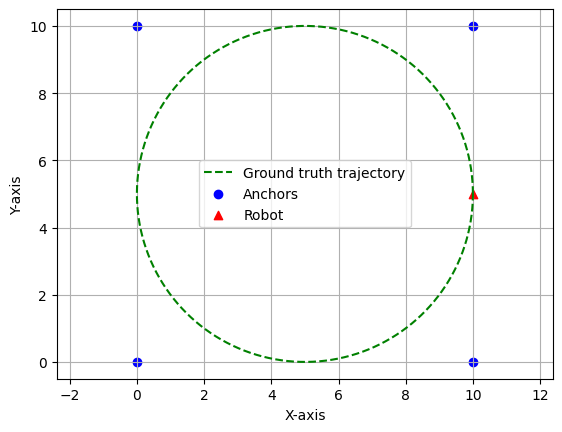

In [8]:
data = np.load('ekf.npz')
plot_robot_setup(data)

In this exercise, you will complete the implementation of an Extended Kalman Filter (EKF) to localize a mobile robot. The robot is equipped with a system of four fixed anchors that provide continuous distance measurements. The robot's goal is to estimate its position $(x, y)$ in 2D space using these distance measurements.

The robot receives measurements of its distances to the four anchors, whose positions are known. The EKF assumes that the state is normally distributed and estimates its probability distribution: the mean $\mathbf{x}$ and the covariance matrix $P$.

### Robot State
The robot's state is represented by the 2D position:

\begin{equation}
\mathbf{x} = \begin{pmatrix} x \\ y \end{pmatrix}
\end{equation}

where:
- x is the robot's position along the x-axis,
- y is the robot's position along the y-axis.

### Distance Measurements
The robot receives distance measurements $z_i$ from each anchor, where $i = 0, 1, 2, 3$ corresponds to the four anchors. The relation between the distance measurement and the state is given by the measurement model $h_i(\mathbf{x}, \eta)$:

\begin{equation}
h_i(\mathbf{x}, \eta) = z_i = \sqrt{(x - a_i)^2 + (y - b_i)^2} + \eta, \quad \eta \sim \mathcal{N}(0, R)
\end{equation}

where $(a_i, b_i)$ represent the coordinates of anchor $i$.  Moreover, $\eta$ represents the normally distributed sensor noise, with zero mean and $Var(\eta)=R$.

### Extended Kalman Filter Equations

The EKF is a recursive algorithm that iterates between two main steps: **Prediction** and **Update**. The goal is to keep track of $\mathbf{x}$ and the covariance matrix $P$.

#### 1. Prediction Step
The general structure of the system dynamics is the following.

\begin{equation}
\mathbf{x}(k+1) = A \mathbf{x}(k) + \mathbf{u} + \rho, \quad \rho \sim \mathcal{N}(0, Q)
\end{equation}

$\mathbf{u}$ is the control input, and $\rho$ the process noise.

In the prediction step, the filter uses the robot's motion model (which could be a linear or non-linear function) to predict the new state $\mathbf{x}$ and its covariance $P$.

\begin{align}
\mathbf{x} &\leftarrow A \mathbf{x} + \mathbf{u}\\
P &\leftarrow A P A^T + Q, \quad Q=Var(\rho)
\end{align}

Where $\mathbf{u}$ represents the control input (e.g., provided by accelerometer), and $A$ is identified fro the laws of motion.

##### Particular for this exercise:
Since this problem gives no information about the robot's motion model, we will model the dynamics with a random walk:

\begin{equation}
\mathbf{x}(k+1) = \mathbf{x}(k) + \rho
\end{equation}

Therefore, the prediction becomes:

\begin{align}
\mathbf{x} &\leftarrow \mathbf{x} \\
P &\leftarrow P + Q
\end{align}

This means that since we have no information on the dynamics, the **Prediction** step does not change the state estimate $\mathbf{x}$. However, a $Q$ matrix of $Q = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$ signifies that the uncertainty in the robot's movement from one timestamp to the next follows a normal distribution with a variance of 1 m (and zero mean).

#### 2. Update Step

The update step corrects the predicted state and covariance using the distance measurements from the anchors. For this purpose, it first computes the Kalman gain $K$, which determines how much weight should be given to the predicted state versus the new measurement during the state update.

\begin{equation}
K \leftarrow P H^T (H P H^T + R)^{-1}
\end{equation}

- $H = \frac{\partial h(\mathbf{x})}{\partial \mathbf{x}}$ is the Jacobian matrix of the measurement model with respect to the state $\mathbf{x}$,
- $R$ is the measurement noise covariance matrix. In our case a scalar.

\begin{equation}
\mathbf{x} \leftarrow  \mathbf{x} + K(z - h_i(\mathbf{x}, 0))
\end{equation}


\begin{equation}
P \leftarrow (I - K H) P (I - K H)^T + K R K^T
\end{equation}


<!-- The Jacobian for this measurement model with respect to the state $\mathbf{x} = \begin{pmatrix} x \\ y \end{pmatrix}$ is: -->

<!-- \begin{equation}
H_i = \begin{pmatrix} \frac{x - a_i}{\sqrt{(x - a_i)^2 + (y - b_i)^2}} & \frac{y - b_i}{\sqrt{(x - a_i)^2 + (y - b_i)^2}} \end{pmatrix}
\end{equation} -->


### Summary: Steps of the EKF Implementation

1. **Initialization**:
   - The initial values of the $\mathbf{x}$ and $P$ are necessary. In this exercise, they are provided.

2. **Prediction step**:
   - Essentially, this step only adds variance. If the prediction step is completely skipped, the covariance will go towards zero and the filter will stop learning.

\begin{align}
\mathbf{x} &\leftarrow \mathbf{x} \\
P &\leftarrow P + Q
\end{align}

3. **Update step**:
\begin{align*}
K &\leftarrow P H^T (H P H^T + R)^{-1} \\
\mathbf{x} &\leftarrow \mathbf{x} + K(z - h_i(\mathbf{x}, 0)) \\
P &\leftarrow (I - K H) P (I - K H)^T + K R K^T
\end{align*}


#### Solve the exercise by complete the fields marked with "TODO"

In [9]:
import numpy as np
from numpy import dot 
import matplotlib.pyplot as plt

In [10]:
# Computes h_i(x, 0)
def compute_measurement(x, anchor_xy):
    z_comp = np.sqrt((x[0] - anchor_xy[0]) ** 2 + (x[1] - anchor_xy[1]) ** 2)
    return z_comp

In [11]:
def comp_H(anchor, x):
    H = np.zeros(2)
    denominator = np.sqrt((x[0] - anchor[0])**2 + (x[1] - anchor[1])**2)
    H[0] = (x[0] - anchor[0]) / denominator
    H[1] = (x[1] - anchor[1]) / denominator
    return H

In [12]:
def update(x, P, R, anchor, z):
    x = x.reshape(2,1)
    H = comp_H(anchor, x).reshape(1, 2)
    inv = 1/(dot(H, P).dot(H.T) + R)
    K = dot(P, H.T) * inv
    
    z_pred = compute_measurement(x, anchor)
    x_upd = x + K * (z - z_pred)
    AUX = (np.identity(2) - np.dot(K, H))
    P_upd = np.dot(AUX, P)
    P_upd = np.dot(P_upd, AUX.T) + R * np.dot(K, K.T)
    return x_upd, P_upd

/tmp/ipykernel_3219/2881321013.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H[0] = (x[0] - anchor[0]) / denominator
/tmp/ipykernel_3219/2881321013.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H[1] = (x[1] - anchor[1]) / denominator


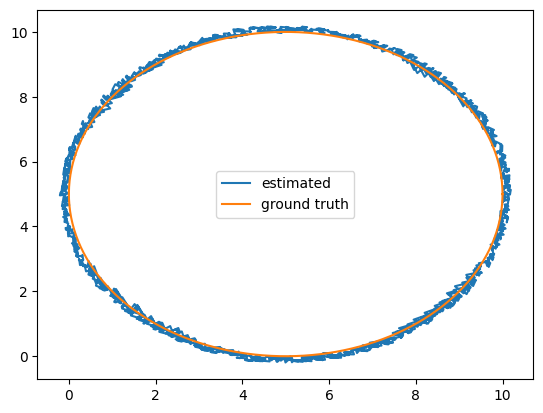

In [13]:
measurements = data['measurements']
x0 = data['x0']
N = len(measurements)

# Filter initialization
P = 0.01 * np.identity(2) # Note that the initial variance is small, so the filter is sure about the initial state value

# Sensor noise covariance matrix
Q = 0.1 * np.identity(2)

# Sensor noise variance
R = 0.2**2

x = x0
x_log = np.zeros((N, 2))
for i in range(N):
    # Prediction step
    x = x + 0
    P = P + Q
    
    # Update step
    anchor = measurements[i, :2]
    distance = measurements[i, 2]
    [x, P] = update(x, P, R, anchor, distance)

    # Log current state
    x_log[i, :] = x.reshape(2)

# Plot trajectory
plot_estimated_trajectory(data, x_log)